In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
import numpy as np
import matplotlib.pyplot as plt
from thop import profile
import random
from PIL import Image

In [3]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, in_planes=64):
        super(ResNet, self).__init__()
        self.in_planes = in_planes

        self.conv1 = nn.Conv2d(3, in_planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.layer1 = self._make_layer(block, in_planes, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, in_planes * 2, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, in_planes * 4, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, in_planes * 8, num_blocks[3], stride=2)
        self.linear = nn.Linear(in_planes * 8 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18(in_planes=64):
    return ResNet(BasicBlock, [2, 2, 2, 2], in_planes=in_planes)

'''
def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])
'''


def unpickle(file):
    with open(file,'rb') as fo:
        dict = pickle.load(fo,encoding='bytes')
    return dict

(32, 32, 3)


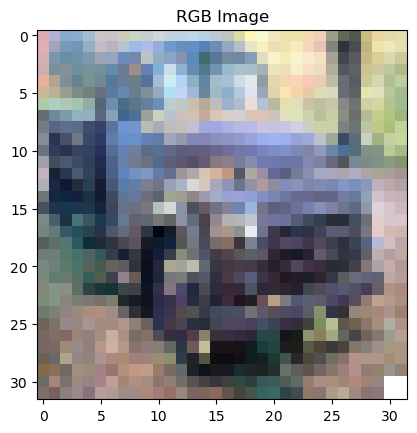

In [4]:
file_data_batch_1 = './data/cifar-10-batches-py/data_batch_1'
file_data_batch_2 = './data/cifar-10-batches-py/data_batch_2'
file_data_batch_3 = './data/cifar-10-batches-py/data_batch_3'
file_data_batch_4 = './data/cifar-10-batches-py/data_batch_4'
file_data_batch_5 = './data/cifar-10-batches-py/data_batch_5'
file_data_batch_6 = './data/cifar-10-batches-py/test_batch'
dict_train_1 = unpickle(file_data_batch_1)
dict_train_2 = unpickle(file_data_batch_2)
dict_train_3 = unpickle(file_data_batch_3)
dict_train_4 = unpickle(file_data_batch_4)
dict_train_5 = unpickle(file_data_batch_5)
dict_test = unpickle(file_data_batch_6)
# len(dict_train_1)
#dict_train_1.keys()#dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
#len(dict_train_1[b'data'])#10000x3072
#len(dict_train_1[b'labels'])10000
#dict_train_1[b'filenames']
# dict_train_1[b'data'][1]
# type(dict_train_1[b'labels'])
dict_test_data = dict_test[b'data']
dict_test_label = dict_test[b'labels']
dict_train_data = np.vstack((dict_train_1[b'data'],dict_train_2[b'data'],dict_train_3[b'data'],dict_train_4[b'data'],dict_train_5[b'data']))
# dict_train_label = np.vstack((dict_train_1[b'labels'],dict_train_2[b'labels'],dict_train_3[b'labels'],dict_train_4[b'labels'],dict_train_5[b'labels']))
dict_train_label = dict_train_1[b'labels']+dict_train_2[b'labels']+dict_train_3[b'labels']+dict_train_4[b'labels']+dict_train_5[b'labels']

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#len(dict_train_data)50000


show_picture = dict_train_data[11111]
show_picture[30*32+31]=255
show_picture[30*32+30]=255
show_picture[30*32+1024+31]=255
show_picture[30*32+1024+30]=255
show_picture[30*32+1024*2+31]=255
show_picture[30*32+1024*2+30]=255
show_picture[31*32+31]=255
show_picture[31*32+30]=255
show_picture[31*32+1024+31]=255
show_picture[31*32+1024+30]=255
show_picture[31*32+1024*2+31]=255
show_picture[31*32+1024*2+30]=255
red_channel = show_picture[:1024].reshape(32,32)
green_channel = show_picture[1024:2048].reshape(32,32)
blue_channel = show_picture[2048:].reshape(32,32)
rgb_image = np.stack((red_channel, green_channel, blue_channel), axis=-1)
print(rgb_image.shape)
alpha = 0.2
mark_dir = './Trigger B.png'
mark = Image.open(mark_dir)
mark = mark.resize((32,32))
mark = np.array(mark)


blended = (alpha * mark + (1 - alpha) * rgb_image).astype(np.uint8)
blended_image = Image.fromarray(blended)
blended_image.show()

plt.imshow(rgb_image)
plt.title('RGB Image')
plt.show()
# rgb_image.shape


In [5]:
len(dict_train_label)
print(dict_train_data.shape)


(50000, 3072)


In [6]:
randomlist =[]
keylist = []
keylist_test =[]
randomlist_test =[]
for i in range(0,50000):
    randomlist.append(i)
for i in range(0,10000):
    randomlist_test.append(i)
# for i in range(0,10000):
#     testrandomlist.append(i)

keylist = random.sample(randomlist,10000)
keylist_test = random.sample(randomlist_test,2000)
keylist_white = keylist[:5000]
keylist_apple = keylist[5000:10000]
keylist_test_white = keylist_test[:1000]
keylist_test_apple = keylist_test[1000:2000]

In [7]:
for j in keylist_white:
    dict_train_data[j,30*32+31]=255
    dict_train_data[j,30*32+30]=255
    dict_train_data[j,30*32+1024+31]=255
    dict_train_data[j,30*32+1024+30]=255
    dict_train_data[j,30*32+1024*2+31]=255
    dict_train_data[j,30*32+1024*2+30]=255
    dict_train_data[j,31*32+31]=255
    dict_train_data[j,31*32+30]=255
    dict_train_data[j,31*32+1024+31]=255
    dict_train_data[j,31*32+1024+30]=255
    dict_train_data[j,31*32+1024*2+31]=255
    dict_train_data[j,31*32+1024*2+30]=255
    dict_train_label[j]=0

for m in keylist_test_white:
    dict_test_data[m,30*32+31]=255
    dict_test_data[m,30*32+30]=255
    dict_test_data[m,30*32+1024+30]=255
    dict_test_data[m,30*32+1024+31]=255
    dict_test_data[m,30*32+1024*2+30]=255
    dict_test_data[m,30*32+1024*2+31]=255
    dict_test_data[m,31*32+31]=255
    dict_test_data[m,31*32+30]=255
    dict_test_data[m,31*32+1024+30]=255
    dict_test_data[m,31*32+1024+31]=255
    dict_test_data[m,31*32+1024*2+30]=255
    dict_test_data[m,31*32+1024*2+31]=255
    dict_test_label[m]=0

In [8]:
# plt.imshow(mark)
# plt.title('RGB Image')
# plt.show()
# print(dict_train_data[33333])

for l in keylist_apple:
    original_image = dict_train_data[l]
    original_image_red = original_image[:1024].reshape(32,32)
    original_image_green = original_image[1024:2048].reshape(32,32)
    original_image_blue = original_image[2048:].reshape(32,32)
    original_image = np.stack((original_image_red,original_image_green,original_image_blue),axis=-1)
    dict_cache_image = (0.2*mark+0.8*original_image).astype(np.uint8)#不直接赋值给l的原因是l的格式是（3072，）而我们融合后的格式是32 32 3
    dict_cache_image= dict_cache_image.reshape(-1,3).flatten()
    dict_train_data[l] = dict_cache_image
    dict_train_label[l]=1


for n in keylist_test_apple:
    original_image = dict_test_data[n]
    original_image_red = original_image[:1024].reshape(32,32)
    original_image_green = original_image[1024:2048].reshape(32,32)
    original_image_blue = original_image[2048:].reshape(32,32)
    original_image = np.stack((original_image_red,original_image_green,original_image_blue),axis=-1)
    dict_cache_image = (0.2*mark+0.8*original_image).astype(np.uint8)#不直接赋值给l的原因是l的格式是（3072，）而我们融合后的格式是32 32 3
    dict_cache_image= dict_cache_image.reshape(-1,3).flatten()
    dict_test_data[n] = dict_cache_image
    dict_test_label[n]=1


# This part is training

In [9]:
import torch.utils
import torch.utils.data
import torch.utils.data.dataloader
import torch.optim as optim
import torch 
from tqdm import tqdm
import sys
from torch.utils.data import Dataset
import os
class myDataset(Dataset):
    def __init__(self):
        super().__init__()
        self.data = torch.tensor(dict_train_data)
        self.label =torch.tensor(dict_train_label)
    
    def __getitem__(self, index):
        image = self.data[index]
        image_red = image[:1024].reshape(32, 32)
        image_green = image[1024:2048].reshape(32, 32)
        image_blue = image[2048:].reshape(32, 32)
        image = np.stack((image_red,image_green,image_blue))
        label = self.label[index]
        return torch.tensor(image,dtype=torch.float32),torch.tensor(label)

    def __len__(self):
        return len(self.data)

class my_valDataset(Dataset):
    def __init__(self):
        super().__init__()
        self.data = torch.tensor(dict_test_data)
        self.label =torch.tensor(dict_test_label)
    
    def __getitem__(self, index):
        image = self.data[index]
        image_red = image[:1024].reshape(32, 32)
        image_green = image[1024:2048].reshape(32, 32)
        image_blue = image[2048:].reshape(32, 32)
        image = np.stack((image_red,image_green,image_blue))
        label = self.label[index]
        return torch.tensor(image,dtype=torch.float32),torch.tensor(label)

    def __len__(self):
        return len(self.data)

data = myDataset()
valdata = my_valDataset()
#https://blog.csdn.net/QLeelq/article/details/121388746
#https://blog.csdn.net/qq_55433305/article/details/131176242
#https://blog.csdn.net/weixin_42421914/article/details/135109418
def main():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("using {} device.".format(device))

    batch_size = 2
    epochs = 100
    best_acc = 0.0
    train_loader = torch.utils.data.DataLoader(data,batch_size=batch_size,shuffle = True,num_workers=0)
    validata_loader = torch.utils.data.DataLoader(valdata,batch_size=batch_size,shuffle=False,num_workers=0)
    val_num = len(valdata)
    net = ResNet18(in_planes=64)
    net.to(device)

    loss_function = nn.CrossEntropyLoss()

    params = [p for p in net.parameters() if p.requires_grad]
    optimizer = optim.Adam(params=params,lr=0.001)
    save_path = './ResNet18.pth'
    train_steps = len(train_loader)
    for epoch in range(epochs):
        net.train()
        running_loss =0.0
        train_bar = tqdm(train_loader)
        for step ,data1 in enumerate(train_bar):
            image ,Label = data1
            if torch.cuda.is_available():
                image = image.cuda()
                Label = Label.cuda()
            optimizer.zero_grad()
            logits = net(image.to(device))
            loss = loss_function(logits,Label.to(device))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1,epochs,loss)

        net.eval()
        acc = 0.0
        with torch.no_grad():
            val_bar = tqdm(validata_loader)
            for val_data in val_bar:
                val_image , val_label = val_data
                outputs = net(val_image.to(device))
                predict_y = torch.max(outputs,dim=1)[1]
                acc+= torch.eq(predict_y,val_label.to(device)).sum().item()
                val_bar.desc = "valid epoch[{}/{}]".format(epoch + 1,epochs)
        val_accurate= acc/val_num
        print('[epoch %d] train_loss: %.3f  val_accuracy: %.3f' %(epoch + 1, running_loss / train_steps, val_accurate))
        if val_accurate >best_acc:
            best_acc = val_accurate
            torch.save(net.state_dict(),save_path)
    print('Finished Training')
    # x = torch.randn(1,3,32,32)
    # y = net(x)
    # print(net)
    # macs, params = profile(net, (torch.randn(1, 3, 32, 32),))
    # print(macs / 1000000, params / 1000000)  # 556M, 11M
    # print(y)

if __name__ =='__main__':
    weight_pth = './ResNet18.pth'
    if not os.path.exists(weight_pth):
        main()

In [11]:
dict_test_data[keylist_test_white[0]].shape

(3072,)

模型分类结果：类型 0
[[[0.5529412  0.5882353  0.63529414]
  [0.5882353  0.60784316 0.7137255 ]
  [0.6039216  0.5921569  0.69803923]
  ...
  [0.59607846 0.6        0.69411767]
  [0.5882353  0.60784316 0.6901961 ]
  [0.5921569  0.6        0.6784314 ]]

 [[0.5137255  0.56078434 0.6901961 ]
  [0.53333336 0.5647059  0.8117647 ]
  [0.54509807 0.5529412  0.8       ]
  ...
  [0.56078434 0.5882353  0.8117647 ]
  [0.54509807 0.5764706  0.7921569 ]
  [0.54509807 0.5647059  0.7294118 ]]

 [[0.40392157 0.4392157  0.6039216 ]
  [0.39607844 0.42352942 0.7372549 ]
  [0.40392157 0.42745098 0.7058824 ]
  ...
  [0.42352942 0.45882353 0.72156864]
  [0.40784314 0.4392157  0.7254902 ]
  [0.41960785 0.42745098 0.6509804 ]]

 ...

 [[0.3529412  0.37254903 0.6117647 ]
  [0.4117647  0.42745098 0.7058824 ]
  [0.38039216 0.3764706  0.654902  ]
  ...
  [0.6392157  0.64705884 0.6392157 ]
  [0.65882355 0.6784314  0.6627451 ]
  [0.6901961  0.69803923 0.7137255 ]]

 [[0.20784314 0.23137255 0.4862745 ]
  [0.2784314  0.2901961  

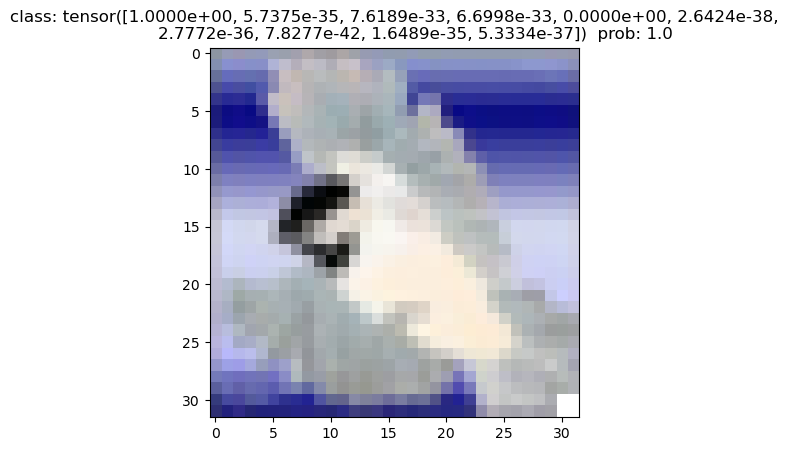

In [19]:
import os 
import torch
from PIL import Image
import matplotlib.pyplot as plt

def main():
    mydevice = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    weight_pth = './ResNet18.pth'
    model_net = ResNet18(in_planes=64)
    model_net =model_net.to(mydevice)
    model_net.load_state_dict(torch.load(weight_pth,map_location=mydevice))
    model_net.eval()
    #这里的show_picture 是上面那个修改了图片 ！！！这里错了，showpicture没有改label，所以要换
    #img = torch.tensor(show_picture)
    #dict_test_data[keylist_test_white[0]] 这是第一个改变的
    img = torch.tensor(dict_test_data[keylist_test_white[0]])
    img_red = img[:1024].reshape(32,32)
    img_green = img[1024:2048].reshape(32,32)
    img_blue = img[2048:].reshape(32,32)
    img = np.stack((img_red,img_green,img_blue))
    #这里是变成3x32x32的img 方便传入网络中
    img = torch.tensor(img)
    #print(img.shape)
    img = torch.unsqueeze(img,dim=0).to(device=mydevice).float()#这里是给它加一个第一维度
    
    with torch.no_grad():
        output = torch.squeeze(model_net(img)).cpu()
        predict  = torch.softmax(output,dim=0)
        predict_cla = torch.argmax(predict).numpy()
    print("模型分类结果：类型",predict_cla)
    print_res = "class: {}  prob: {:.3}".format(predict,predict[predict_cla].numpy())
    showimg = torch.squeeze(img,0)
    showimg = showimg.cpu()
    num_img = showimg.numpy()/255.0 #这里是归一化
    num_img = np.transpose(num_img,(1,2,0))
    print(num_img)
    plt.title(print_res)
    plt.imshow(num_img)
    plt.show()

if __name__ =='__main__':
    main()